************ 3 -Channel Conventional Pan_Sharpening ************

# Packages


In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import tifffile as tiff
from sklearn.decomposition import PCA as princomp
import pywt

def upsample_bicubic(img,ratio):
    h,w,c=img.shape
    
    fimg=cv.resize(img,(w*ratio,h*ratio),cv.INTER_CUBIC)
    return fimg
def downsample_bicubic(img,ratio):
    h,w,c=img.shape
    
    fimg=cv.resize(img,(int(w/ratio),int(h/ratio)),cv.INTER_CUBIC)
    return fimg

# Quantitative Metrics

In [2]:
def rmse(out,inn):
    m,n,c=ms.shape
    rmse= pow(np.mean((inn-out)**2),0.5)
    return rmse

def sam(out,inn):
    m,n,c=ms.shape
    inn=np.reshape(inn,(1,m*n*c))
    out=np.reshape(out,(1,m*n*c))
    mag_ms=np.linalg.norm(inn)
    mag_out=np.linalg.norm(out)
    prod = np.dot(inn,out.T)
    sam= np.arccos(prod/(mag_ms*mag_out))
    return sam

def uqi(out,inn):
    m,n,c=ms.shape
    inn=np.reshape(inn,(1,m*n*c))
    out=np.reshape(out,(1,m*n*c))
    l=m*n*c
    
    inn_m=np.mean(inn)  # x_bar
    out_m=np.mean(out)  # y_bar
    inn_s= np.sum((inn-inn_m)**2)/(l-1)             # sigma_x^2
    out_s= np.sum((out-out_m)**2)/(l-1)             # sigma_y^2
    com_s= np.sum((inn-inn_m)*(out-out_m))/(l-1)    # sigma_xy 
    
    uqi= (4*com_s*inn_m*out_m)/((inn_s + out_s)*(inn_m**2 + out_m**2))
    return uqi

def erga(out,inn,r):
    m,n,c=ms.shape
    s=0
    for i in range(c):
        s += (rmse(out[:,:,i],inn[:,:,i]))/(np.mean(inn[:,:,i])**2)    
    erga= 100*r*((s/c)**0.5)
    return erga

# Wavelet method

(1792, 1792, 1)
(1792, 1792, 1)
(1792, 1792, 1)
(1792, 1792, 3)
rmse: 934.3112868480088
sam: [[0.23922082]]
uqi: 0.6278379928680379
erga: 4.764971964575868


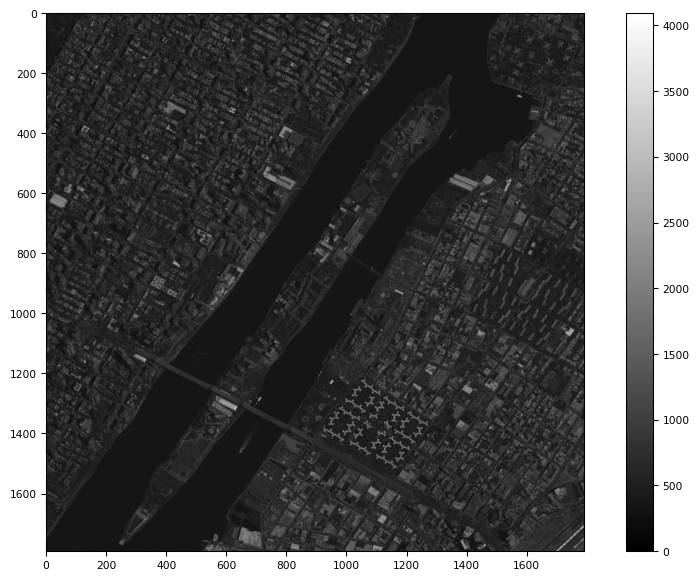

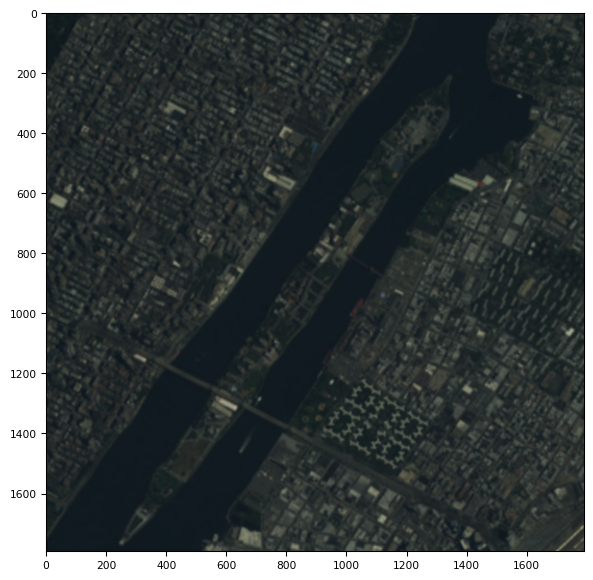

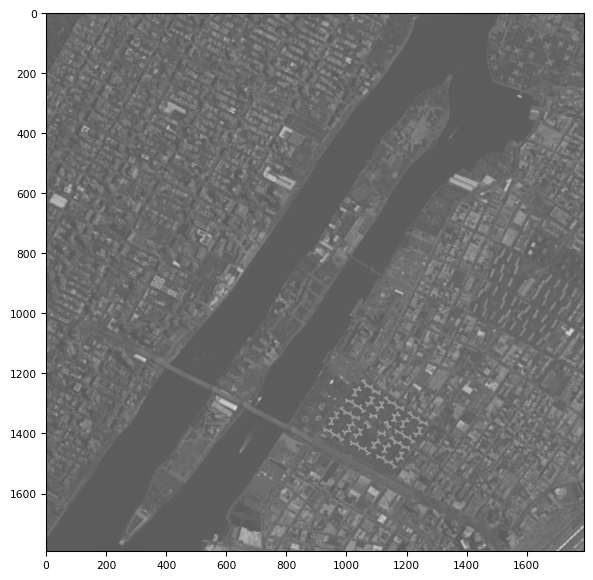

In [5]:
###################     Substitution wavelet method   ##################33

def wavelets(pan,ms):
    M,N,C=pan.shape
    m,n,c=ms.shape
    
    ratio=int(round(M/m))
    assert int(round(M/m))==int(round(N/n))
    
    u_ms=upsample_bicubic(ms,ratio)
    
    i=np.mean(u_ms,axis=-1)        #intensity component of rgb
    gain=np.std(i,axis=(0,1))/np.std(pan,axis=(0,1))
    bias=np.mean(i,axis=(0,1)) + gain*np.mean(pan,axis=(0,1))
    pan_mod= gain*pan + bias
    
    pan_mod=np.squeeze(pan_mod)
    pc=pywt.wavedec2(pan_mod,'haar',level=2)
    
    rec=[]
    for i in range(c):
        temp=pywt.wavedec2(u_ms[:,:,i],'haar',level=2)
        #print(temp[1].shape)
        temp[0]=pc[0]
        
        temp_rec=pywt.waverec2(temp,'haar')
        temp_rec=np.expand_dims(temp_rec,-1)
        print(temp_rec.shape)
        rec.append(temp_rec)
        
    Inv=np.concatenate(rec,axis=-1)
    print(Inv.shape)
    
    #Inv = Inv/Inv.max()
    Inv[Inv<0]=0
    #Inv[Inv>1]=1
        
    return Inv
    
pan=tiff.imread("C:/Users/Aniket/Desktop/Image processing project/pansharpening/dataset/PAirMax/FR/PAN/PAN5.tif")
pan=np.expand_dims(pan,axis=-1)

ms=tiff.imread("D:/ECE/Image processing project/rgb_MS5.tif")
tiff.imshow(pan,cmap='gray')
tiff.imshow(ms)

pan_out= wavelets(pan,ms)

tiff.imshow(pan_out)

err=rmse(pan_out,ms)
err2=sam(pan_out,ms)
err3=uqi(pan_out,ms)
err4=erga(pan_out,ms,r=1)
print('rmse:',err)
print("sam:",err2)
print("uqi:",err3)
print("erga:",err4)

(1792, 1792, 1)
(1792, 1792, 3)
rmse: 6451.8704264732405
sam: [[0.11966841]]
uqi: 0.04662308943622559
erga: 12.359985237044157


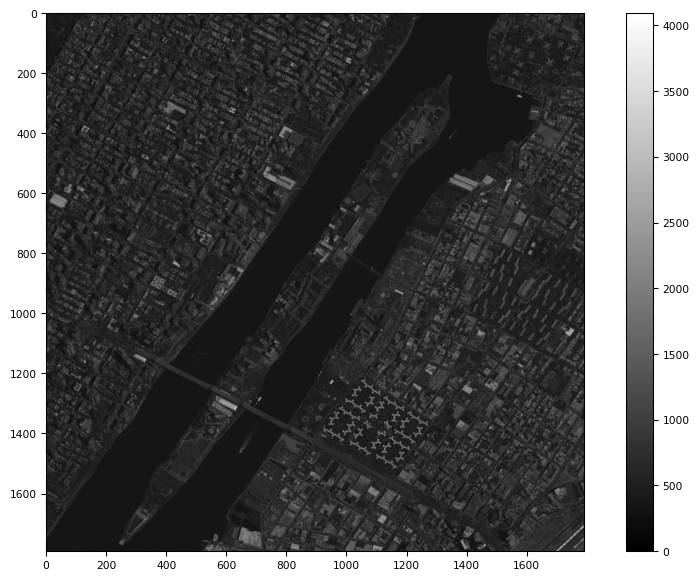

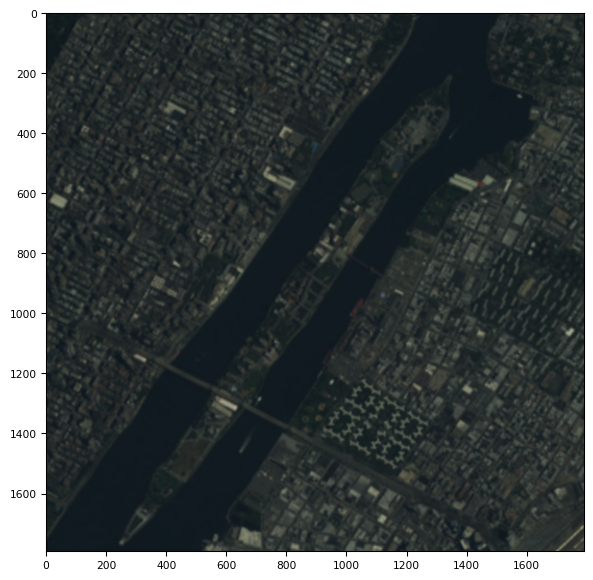

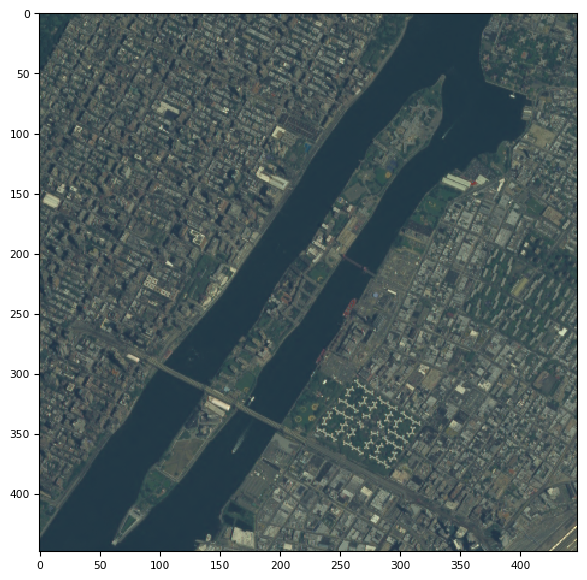

In [23]:
###################  addition wavelet method  ###############

import matplotlib
def add_wavelet(pan,ms):
    M,N,C=pan.shape
    m,n,c=ms.shape
    
    ratio=int(round(M/m))
    
    u_ms=upsample_bicubic(ms,ratio)
    hsv=matplotlib.colors.rgb_to_hsv(u_ms[:,:,0:3])
    
    
    gain=np.std(hsv[2],axis=(0,1))/np.std(pan,axis=(0,1))
    bias=np.mean(hsv[2],axis=(0,1)) + gain*np.mean(pan,axis=(0,1))
    pan_mod= gain*pan + bias
    
    pan_mod=np.squeeze(pan_mod)
    pc=pywt.wavedec2(pan_mod,'haar',level=2)
    M1,N1=pc[0].shape
    d_hsv=downsample_bicubic(hsv,int(round(m/M1)))
    
    d_hsv[:,:,2]=d_hsv[:,:,2] + pc[0]
    
    rgb=matplotlib.colors.hsv_to_rgb(d_hsv)
    
    return(rgb)

pan=tiff.imread("C:/Users/Aniket/Desktop/Image processing project/pansharpening/dataset/PAirMax/FR/PAN/PAN5.tif")
pan=np.expand_dims(pan,axis=-1)
print(pan.shape)
ms=tiff.imread("D:/ECE/Image processing project/rgb_MS5.tif")
print(ms.shape)



tiff.imshow(pan,cmap='gray')
tiff.imshow(ms)
pan_out = add_wavelet(pan,ms)


tiff.imshow(pan_out)

pan_out=upsample_bicubic(pan_out,4)
err=rmse(pan_out,ms)
err2=sam(pan_out,ms)
err3=uqi(pan_out,ms)
err4=erga(pan_out,ms,r=1)
print('rmse:',err)
print("sam:",err2)
print("uqi:",err3)
print("erga:",err4)

# PCA  Method

(1792, 1792, 3)
rmse: 1.8892401108827522e-12
sam: [[0.]]
uqi: 1.0000000000000007
erga: 1.7868160232012932e-07


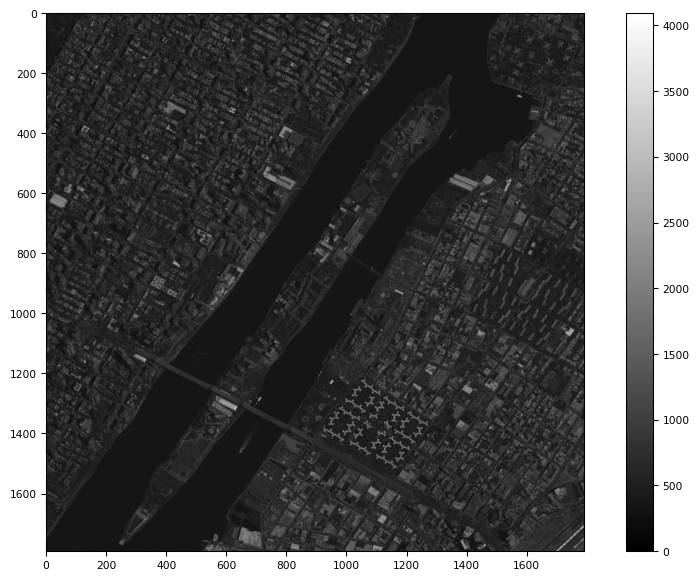

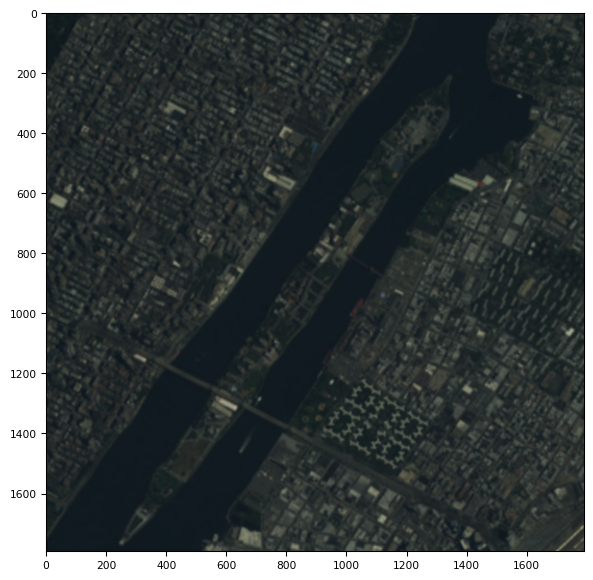

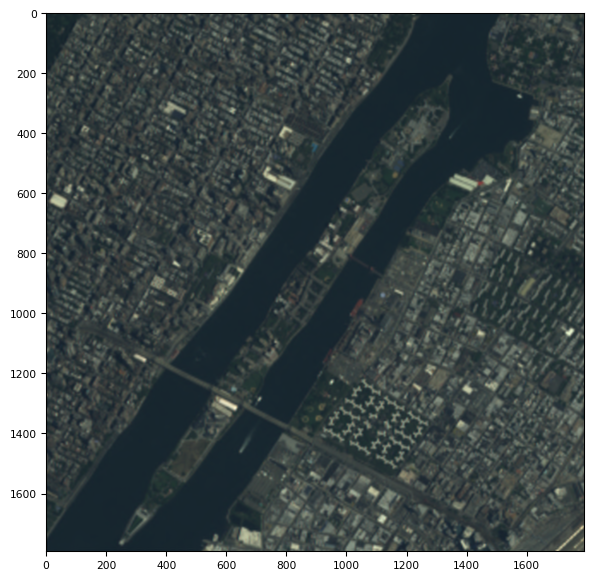

In [7]:
####                    PCA - method          #####
def pca_try(pan,ms):
    M,N,C=pan.shape
    m,n,c=ms.shape
    
    ratio=int(round(M/m))
    assert int(round(M/m))==int(round(N/n))
    
    u_ms=upsample_bicubic(ms,ratio)
    
    p=princomp(n_components=c)
    ms_pca=p.fit_transform(np.reshape(u_ms,(M*N,c)))
    ms_pca=np.reshape(ms_pca,(M,N,c))
    
    pca1=ms_pca[:,:,0]
    gain=np.std(pca1,axis=(0,1))/np.std(pan,axis=(0,1))
    bias=np.mean(pca1,axis=(0,1)) - gain*np.mean(pan,axis=(0,1))
    pan_mod=pan*gain +bias
    #print(pca1.shape)
    #print(pan.shape)
    pan_mod=np.squeeze(pan_mod)
    pca1=pan_mod
    
    ms_ipca=p.inverse_transform(ms_pca)
    return ms_ipca


pan=tiff.imread("C:/Users/Aniket/Desktop/Image processing project/pansharpening/dataset/PAirMax/FR/PAN/PAN5.tif")
pan=np.expand_dims(pan,axis=-1)
ms=tiff.imread("D:/ECE/Image processing project/rgb_MS5.tif")
print(ms.shape)

pan_out = pca_try(pan,ms)
tiff.imshow(pan,cmap='gray')
tiff.imshow(ms)
tiff.imshow(pan_out)

err=rmse(pan_out,ms)
err2=sam(pan_out,ms)
err3=uqi(pan_out,ms)
err4=erga(pan_out,ms,r=1)
print('rmse:',err)
print("sam:",err2)
print("uqi:",err3)
print("erga:",err4)

# Gram-Schmidt (GS) Method

(1792, 1792, 1)
(1792, 1792, 3)
(1792, 1792, 1)
(1792, 1792)
rmse: 59.024879356913225
sam: [[1.57079632]]
uqi: 0.958160094709561
erga: 1.0174757027332162


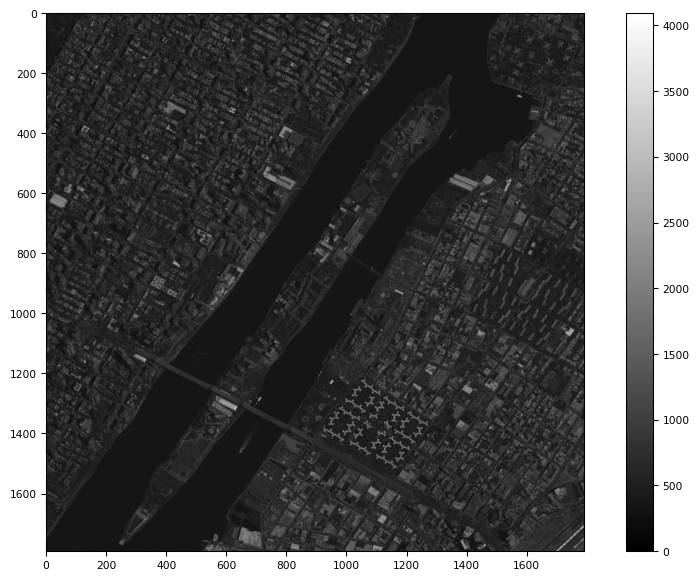

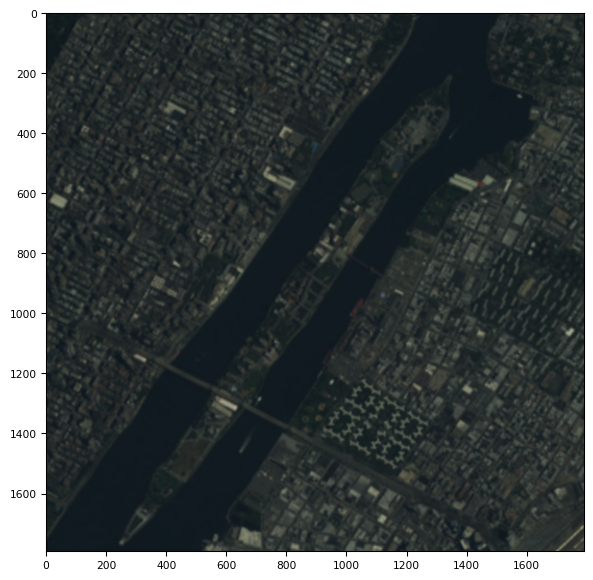

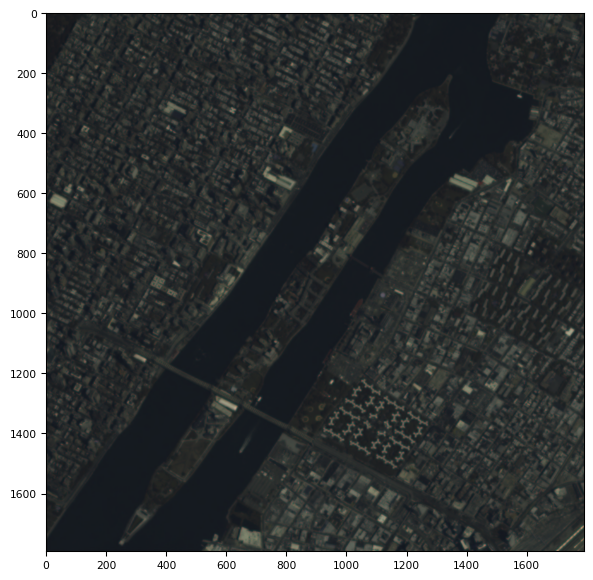

In [8]:
#########                   Modified-gs-transform
import numpy as np

def GS_method(pan, hs):

    M, N, c = pan.shape
    m, n, C = hs.shape
    
    
    ratio = int(np.round(M/m))
    hs=upsample_bicubic(hs,ratio)
    
    #creating low_resolution pan band
    blur = cv.GaussianBlur(pan, (5,5),1)
    blur = np.expand_dims(blur,axis=-1)
    print(blur.shape)
    dw = downsample_bicubic(blur,ratio)
    dw = np.expand_dims(dw,axis=-1)
    up = upsample_bicubic(dw,ratio)
    pan_lr= up
    print(pan_lr.shape)
    
    hs[:,:,0]=pan_lr   #replacing first channel by the low resolution pan band
    

    gs = np.zeros(hs.shape)
    gs[:,:,0]= pan_lr
    
    #applying gs transform
    for i in range(1,c):
        hs_mean = np.mean(hs[:,:,i])
        hs_norm = hs[:,:,i]-hs_mean
        s = 0
        for l in range(i):    #doubt
            phi = (np.cov(hs[:,:,i],gs[:,:,l]))/(np.cov(gs[:,:,l],gs[:,:,l]))
            #print(phi.shape)
            s += phi*gs[:,:,l]
        gs[:,:,i] = hs_norm-s
    
    #matching the mean count and std deviation of the pan image with the first gs band
    gain=np.std(gs[:,:,0],axis=(0,1))/np.std(pan,axis=(0,1))
    bias= np.mean(gs[:,:,0],axis=(0,1)) - gain*np.mean(pan,axis=(0,1))
    pan_modified= pan*gain +bias
    
    
    #applying inverse gs transform
    pan_modified=np.squeeze(pan_modified,axis=2)
    gs[:,:,0]=pan_modified
    
    for i in range(1,c):
        hs_mean = np.mean(hs[:,:,i])
        hs_norm = gs[:,:,i] + hs_mean
        s = 0
        for l in range(i):
            phi = (np.cov(hs[:,:,i],gs[:,:,l]))/(np.cov(gs[:,:,l],gs[:,:,l]))
            s += phi*gs[:,:,l]
        hs[:,:,i] = hs_norm + s
    return hs


pan=tiff.imread("C:/Users/Aniket/Desktop/Image processing project/pansharpening/dataset/PAirMax/FR/PAN/PAN5.tif")
pan=np.expand_dims(pan,axis=-1)
print(pan.shape)
ms=tiff.imread("D:/ECE/Image processing project/rgb_MS5.tif")
print(ms.shape)

pan_out = GS_method(pan,ms)
tiff.imshow(pan,cmap='gray')
tiff.imshow(ms)
tiff.imshow(pan_out)

err=rmse(pan_out,ms)
err2=sam(pan_out,ms)
err3=uqi(pan_out,ms)
err4=erga(pan_out,ms,r=1)
print('rmse:',err)
print("sam:",err2)
print("uqi:",err3)
print("erga:",err4)

# IHS Method

(1792, 1792, 1)
(1792, 1792, 3)
rmse: 115.79560795485013
sam: [[0.16696028]]
uqi: 0.8821198325579777
erga: 1.6697214215806062


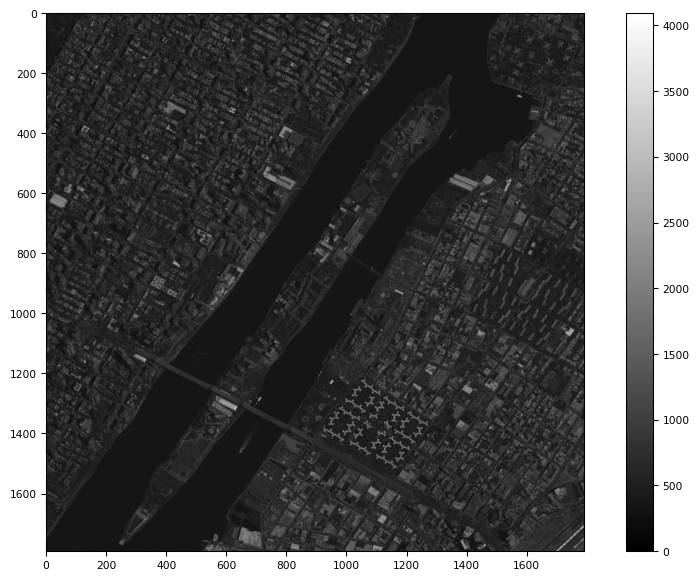

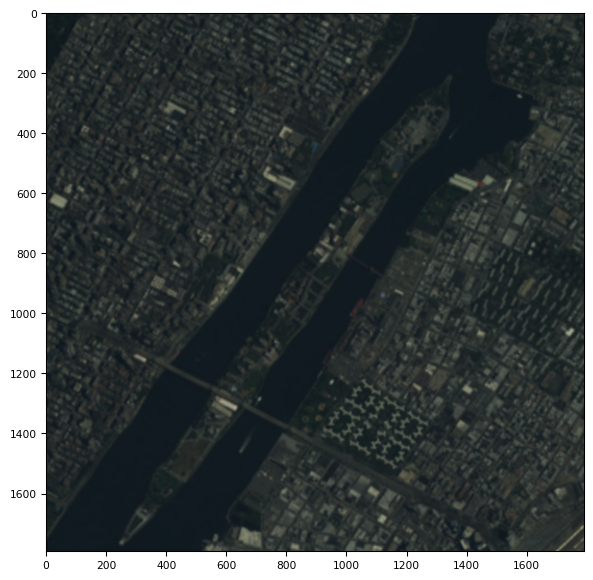

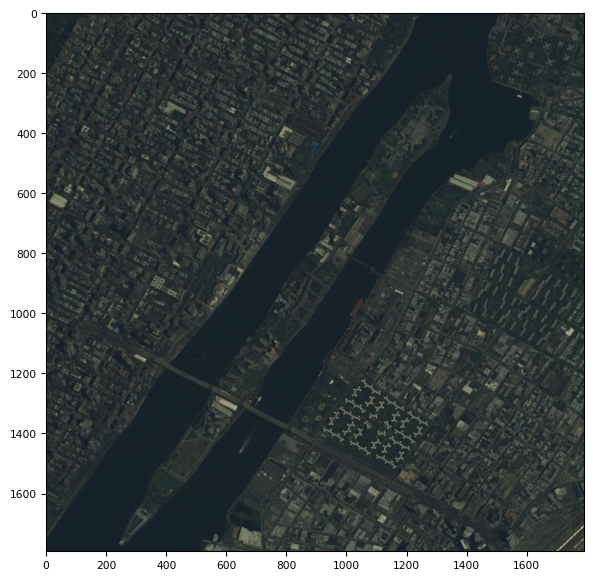

In [10]:
# IHS transform
import numpy as np

def IHS(pan, hs):

    M, N, c = pan.shape
    m, n, C = hs.shape
    
    ratio = int(np.round(M/m)) 
             
        
           
    assert int(np.round(M/m)) == int(np.round(N/n))
    
     #upsample
    u_hs = upsample_bicubic(hs, ratio)
    
    I = np.mean(hs, axis=-1, keepdims=True)  # I=R+G+B /3 mean along the channels --> the IHS transform
#     print(I.shape)
    
    P = (pan - np.mean(pan,axis=(0,1)))*np.std(I, axis=(0,1))/np.std(pan, axis=(0,1))+np.mean(I,axis=(0,1))
    
    I_IHS = u_hs + np.tile(P-I, (1, 1, C))
    
    #adjustment
    #I_IHS[I_IHS<0]=0
    #I_IHS[I_IHS>1]=1
    return I_IHS

pan=tiff.imread("C:/Users/Aniket/Desktop/Image processing project/pansharpening/dataset/PAirMax/FR/PAN/PAN5.tif")
pan=np.expand_dims(pan,axis=-1)
print(pan.shape)
ms=tiff.imread("D:/ECE/Image processing project/rgb_MS5.tif")
print(ms.shape)

pan_out = IHS(pan,ms)
tiff.imshow(pan,cmap='gray')
tiff.imshow(ms)

tiff.imshow(pan_out)


err=rmse(pan_out,ms)
err2=sam(pan_out,ms)
err3=uqi(pan_out,ms)
err4=erga(pan_out,ms,r=1)
print('rmse:',err)
print("sam:",err2)
print("uqi:",err3)
print("erga:",err4)